In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atm-data/cluster2_data.csv
/kaggle/input/atm-data/cluster1_data.csv
/kaggle/input/atm-data/culster_data0_more_features.csv
/kaggle/input/atm-data/df_only_representative_atms.csv
/kaggle/input/atm-data/final_data_cleaned_ready.csv
/kaggle/input/atm-data/atm_data.csv
/kaggle/input/atm-data/best_model_params.json
/kaggle/input/atm-data/df_features.csv
/kaggle/input/atm-data/cluster3_data.csv
/kaggle/input/atm-data/cluster0_data.csv
/kaggle/input/atm-data/culster_data3_more_features.csv
/kaggle/input/atm-data/df_more_features.csv
/kaggle/input/atm-data/culster_data2_more_features.csv
/kaggle/input/atm-data/culster_data1_more_features.csv


In [2]:
df=pd.read_csv('/kaggle/input/atm-data/culster_data1_more_features.csv')

In [3]:
import pandas as pd

# Create the aggregated dataframe
daily_totals = df.groupby(pd.to_datetime(df['date']).dt.date)['amount_original'].sum().reset_index()
daily_totals.columns = ['date', 'total_amount']

daily_totals['date'] = pd.to_datetime(daily_totals['date'])

# Sort by date
daily_totals = daily_totals.sort_values('date')

# Display the first few rows to verify
print(daily_totals.head())


        date  total_amount
0 2022-07-01   175951000.0
1 2022-07-02   128441600.0
2 2022-07-03    82605300.0
3 2022-07-04   146027700.0
4 2022-07-05   151561800.0


In [4]:
daily_totals=daily_totals.set_index('date')

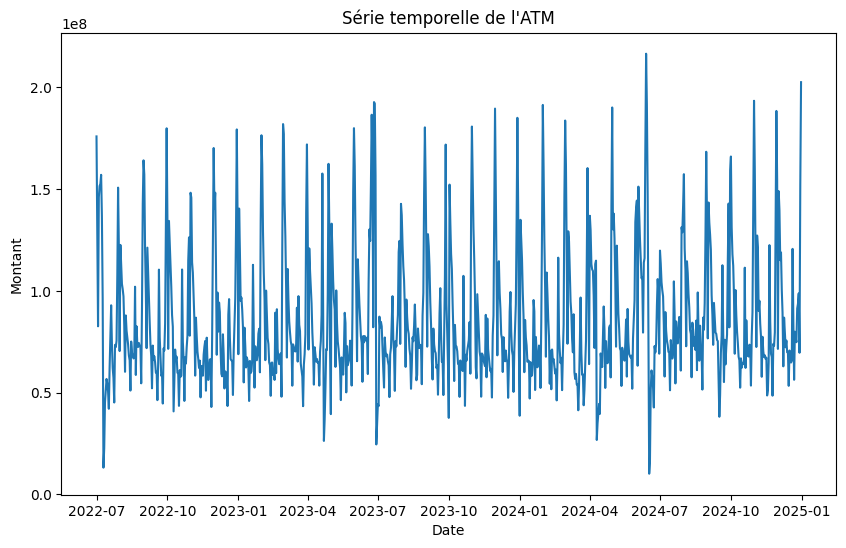

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(daily_totals.index, daily_totals['total_amount'])
plt.title('Série temporelle de l\'ATM')
plt.xlabel('Date')
plt.ylabel('Montant')
plt.show()

In [6]:
daily_totals=pd.DataFrame(daily_totals)

In [7]:
import pandas as pd
import numpy as np


# Step 2: Create lag features (1-7 days and 14 days)
for lag in range(1, 8):
    daily_totals[f'lag_{lag}'] = daily_totals['total_amount'].shift(lag)

# Add 14-day lag
daily_totals['lag_14'] = daily_totals['total_amount'].shift(14)

# Step 4: Add day of week, month features
daily_totals['day_of_week'] = daily_totals.index.dayofweek
daily_totals['month'] = daily_totals.index.month
daily_totals['day'] = daily_totals.index.day
daily_totals['quarter'] =daily_totals.index.quarter
daily_totals['year'] = daily_totals.index.year
daily_totals['is_weekend'] = (daily_totals['day_of_week'] >= 5).astype(int)
daily_totals['is_month_start'] = daily_totals.index.is_month_start.astype(int)
daily_totals['is_month_end'] = daily_totals.index.is_month_end.astype(int)

# Step 5: Add cyclical encoding for time features (better than one-hot for time series)
daily_totals['day_of_week_sin'] = np.sin(2 * np.pi * daily_totals['day_of_week'] / 7)
daily_totals['day_of_week_cos'] = np.cos(2 * np.pi * daily_totals['day_of_week'] / 7)
daily_totals['month_sin'] = np.sin(2 * np.pi * daily_totals['month'] / 12)
daily_totals['month_cos'] = np.cos(2 * np.pi * daily_totals['month'] / 12)

# Step 6: Add interaction features
daily_totals['prev_day_diff'] = daily_totals['total_amount'].shift(1) - daily_totals['total_amount'].shift(2)
daily_totals['week_over_week_diff'] = daily_totals['total_amount'].shift(1) - daily_totals['total_amount'].shift(8)

# Step 7: Drop rows with NaN values (first 14 rows due to lag features)
daily_totals = daily_totals.dropna()

print(f"shape: {daily_totals.shape}")


# Optional: If you want to save this enhanced dataset
# daily_df_clean.to_csv('time_series_features.csv', index=False)

shape: (901, 23)


In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_totals['total_amount'])

print('Statistique ADF:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("La série est stationnaire.")
else:
    print("La série n'est pas stationnaire.")

Statistique ADF: -12.288635413053058
p-value: 7.919717064718908e-23
La série est stationnaire.


In [9]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
X = daily_totals[['lag_1', 'lag_2', 'lag_3', 'lag_4','lag_5','lag_6','lag_7']]
X = sm.add_constant(X)  
y = daily_totals['total_amount']

model = sm.OLS(y, X).fit()

bp_test = het_breuschpagan(model.resid, model.model.exog)


print('Statistique de Breusch-Pagan:', bp_test[0])
print('p-value:', bp_test[1])

if bp_test[1] < 0.05:
    print("Présence d'hétéroscédasticité (variance non constante).")
else:
    print("Pas d'hétéroscédasticité (variance constante).")


Statistique de Breusch-Pagan: 54.846545040900516
p-value: 1.5990108376014755e-09
Présence d'hétéroscédasticité (variance non constante).


In [10]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Appliquer la transformation Box-Cox directement
transformed_data, lambda_value = stats.boxcox(daily_totals['total_amount'])

# Ajouter les données transformées au dataframe
daily_totals['boxcox_total_amount'] = transformed_data

print(f"Paramètre lambda optimal pour Box-Cox: {lambda_value}")


Paramètre lambda optimal pour Box-Cox: -0.0344921282168119


In [11]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
X = daily_totals[['lag_1', 'lag_2', 'lag_3', 'lag_4','lag_5','lag_6','lag_7']]
X = sm.add_constant(X)  
y = daily_totals['boxcox_total_amount']

model = sm.OLS(y, X).fit()

bp_test = het_breuschpagan(model.resid, model.model.exog)


print('Statistique de Breusch-Pagan:', bp_test[0])
print('p-value:', bp_test[1])

if bp_test[1] < 0.05:
    print("Présence d'hétéroscédasticité (variance non constante).")
else:
    print("Pas d'hétéroscédasticité (variance constante).")


Statistique de Breusch-Pagan: 73.00980963700859
p-value: 3.6336979343585996e-13
Présence d'hétéroscédasticité (variance non constante).


In [12]:
!pip install arch

In [13]:
from arch import arch_model

# Ajuster un modèle GARCH sur les résidus
resid = model.resid
garch_model = arch_model(resid, vol='GARCH', p=1, q=1)
garch_results = garch_model.fit(disp='off')
print(garch_results.summary())

# Ou directement sur la série transformée
y_series = daily_totals['boxcox_total_amount']
garch_y = arch_model(y_series, vol='GARCH', p=1, q=1, mean='AR', lags=7)
garch_y_results = garch_y.fit(disp='off')
print(garch_y_results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                491.351
Distribution:                  Normal   AIC:                          -974.703
Method:            Maximum Likelihood   BIC:                          -955.489
                                        No. Observations:                  901
Date:                Thu, May 08 2025   Df Residuals:                      900
Time:                        15:21:24   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1310e-03  4.792e-03      0.236      0.813 

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0215. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


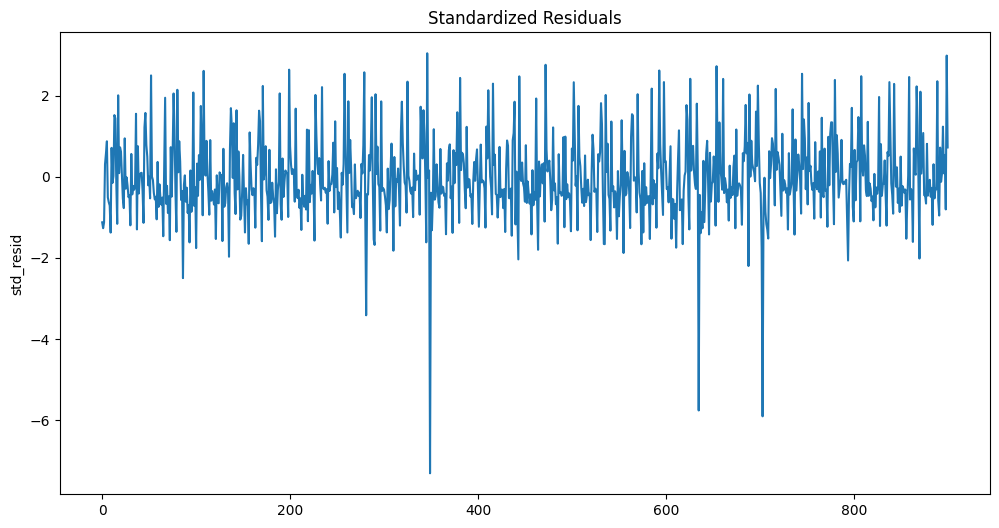

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Standardized residuals
std_resid = garch_results.std_resid

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(len(std_resid)), y=std_resid)
plt.title("Standardized Residuals")
plt.show()


In [15]:
from arch import arch_model

# Test for remaining ARCH effects
arch_test = arch_model(std_resid, vol='ARCH', p=1).fit(disp='off')
print(arch_test.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              std_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1277.87
Distribution:                  Normal   AIC:                           2561.73
Method:            Maximum Likelihood   BIC:                           2576.14
                                        No. Observations:                  901
Date:                Thu, May 08 2025   Df Residuals:                      900
Time:                        15:21:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0365  3.323e-02     -1.097      0.272 [ -0.102,

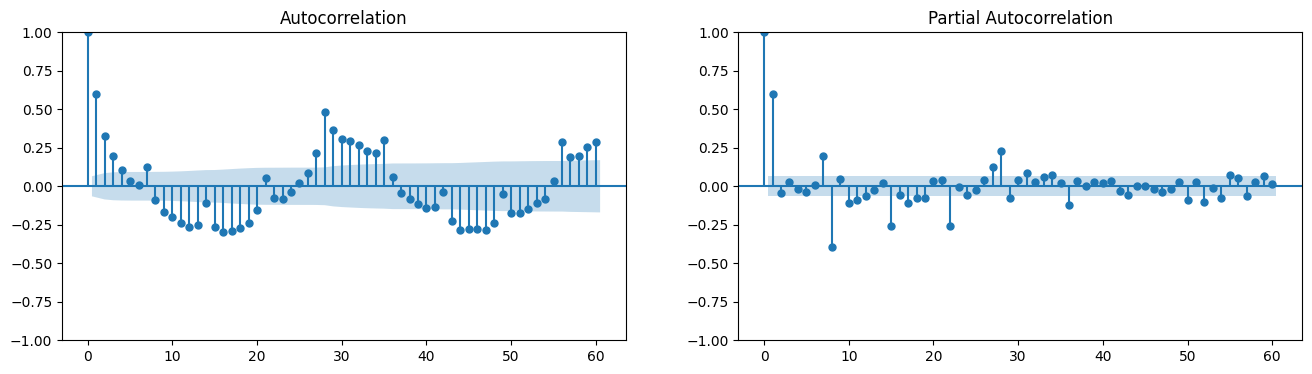

In [16]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = daily_totals['boxcox_total_amount']

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(series, lags=60, ax=axes[0])
plot_pacf(series, lags=60, ax=axes[1])
plt.show()

In [17]:
daily_totals['rolling_mean_7'] = daily_totals['boxcox_total_amount'].shift(1).rolling(window=7).mean()

# 14-day moving average
daily_totals['rolling_mean_14'] = daily_totals['boxcox_total_amount'].shift(1).rolling(window=14).mean()

# 7-day standard deviation (volatility)
daily_totals['rolling_std_7'] = daily_totals['boxcox_total_amount'].shift(1).rolling(window=7).std()

# 7-day min and max
daily_totals['rolling_min_7'] = daily_totals['boxcox_total_amount'].shift(1).rolling(window=7).min()
daily_totals['rolling_max_7'] = daily_totals['boxcox_total_amount'].shift(1).rolling(window=7).max()

In [18]:
lag_columns = [f'lag_{i}' for i in range(1, 8)] + ['lag_14']

# Apply the same Box-Cox transformation to each lag
for lag in lag_columns:
    daily_totals[f'boxcox_{lag}'] = stats.boxcox(daily_totals[lag], lmbda=lambda_value)

In [19]:
import numpy as np
from arch import arch_model

# Extract the relevant lags (1 to 7 and 14)
lag_columns = [f'boxcox_lag_{i}' for i in range(1, 8)] + ['boxcox_lag_14']
X = daily_totals[lag_columns].dropna().values  # Drop NaNs caused by lagging
y_series = daily_totals['boxcox_total_amount'] # Align with lags

# Fit the ARX-GARCH model
garch_y = arch_model(y_series, vol='GARCH', p=1, q=1, mean='ARX', lags=0, x=X)
garch_y_results = garch_y.fit(disp='off')
print(garch_y_results.summary())


                           AR-X - GARCH Model Results                          
Dep. Variable:     boxcox_total_amount   R-squared:                       0.351
Mean Model:                       AR-X   Adj. R-squared:                  0.345
Vol Model:                       GARCH   Log-Likelihood:                495.969
Distribution:                   Normal   AIC:                          -967.939
Method:             Maximum Likelihood   BIC:                          -910.297
                                         No. Observations:                  901
Date:                 Thu, May 08 2025   Df Residuals:                      892
Time:                         15:21:25   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          4.2735      0.951      4.493  7

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.02152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [20]:
daily_totals=daily_totals.dropna()

In [21]:
daily_totals.columns

Index(['total_amount', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_14', 'day_of_week', 'month', 'day', 'quarter', 'year',
       'is_weekend', 'is_month_start', 'is_month_end', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'prev_day_diff',
       'week_over_week_diff', 'boxcox_total_amount', 'rolling_mean_7',
       'rolling_mean_14', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7',
       'boxcox_lag_1', 'boxcox_lag_2', 'boxcox_lag_3', 'boxcox_lag_4',
       'boxcox_lag_5', 'boxcox_lag_6', 'boxcox_lag_7', 'boxcox_lag_14'],
      dtype='object')

In [22]:
daily_totals=daily_totals.drop(columns=['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'lag_14'])

In [25]:
from statsmodels.tsa.arima.model import ARIMA

y_train = daily_totals['boxcox_total_amount'][:'2024-09-30']
X_train = daily_totals.loc[:'2024-09-30'].drop(columns=['boxcox_total_amount','total_amount'])
y_test = daily_totals['boxcox_total_amount']['2024-10-01':'2024-12-31']
X_test = daily_totals.loc['2024-10-01':'2024-12-31'].drop(columns=['boxcox_total_amount','total_amount'])


In [26]:
for column in X_train.columns:
    is_constant = (X_train[column] == X_train[column].iloc[0]).all()
    if is_constant:
        print(f"Column '{column}' has constant values: {X_train[column].iloc[0]}")

In [34]:
model = ARIMA(y_train, order=(1, 0, 1), exog=X_train)
result = model.fit()

print(result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     boxcox_total_amount   No. Observations:                  795
Model:                  ARIMA(1, 0, 1)   Log Likelihood                 628.468
Date:                 Thu, 08 May 2025   AIC                          -1194.936
Time:                         15:43:08   BIC                          -1049.907
Sample:                     07-29-2022   HQIC                         -1139.206
                          - 09-30-2024                                         
Covariance Type:                   opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.3825    1.5e-06  -4.26e+06      0.000      -6.383      -6.383
day_of_week            -0.0847      0.002    -40.596      0.000      -0.089      -0.081
month   

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get predictions for the training and test sets
train_preds = result.predict(start=0, end=len(y_train)-1, exog=X_train)
test_preds = result.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)

# Calculate RMSE and MAE for the training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_mae = mean_absolute_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Calculate RMSE and MAE for the testing set
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

# Print the results
print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R²: {train_r2}")
print(f"Testing RMSE: {test_rmse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing R²: {test_r2}")


Training RMSE: 0.10975953512045968
Training MAE: 0.06817403737017001
Training R²: 0.6615792265406317
Testing RMSE: 0.09289704746731461
Testing MAE: 0.06379492780633575
Testing R²: 0.7122602989278219


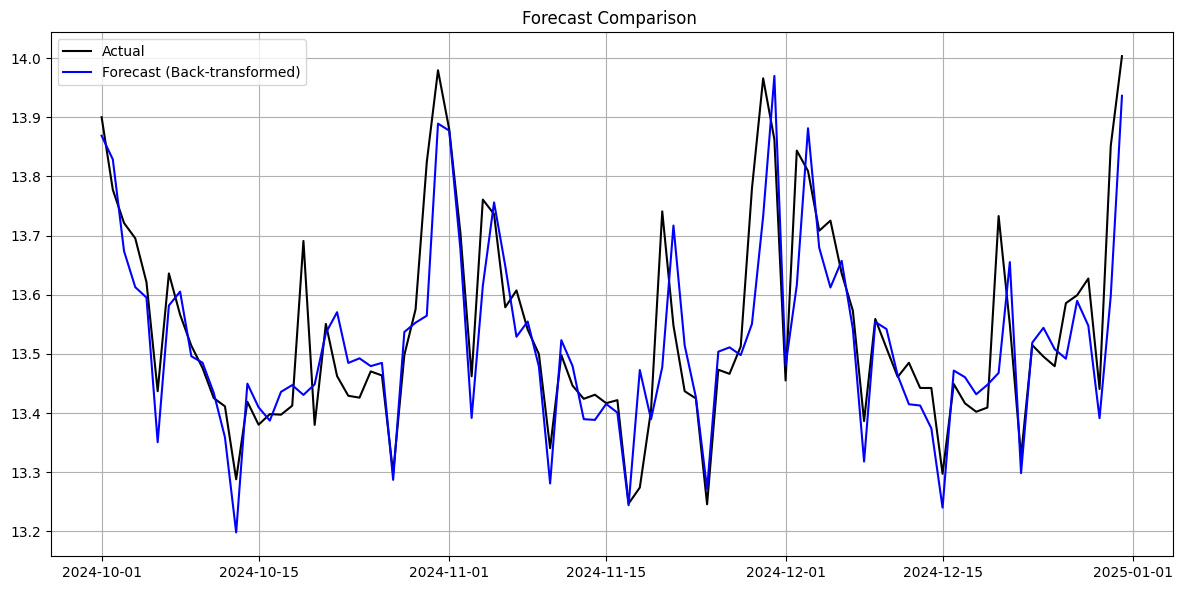

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')  # use y_test_real here for original scale
plt.plot(y_test.index, test_preds, label='Forecast (Back-transformed)', color='blue')
plt.title('Forecast Comparison ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()